# Preparation

I use Python 3, but everything should work with Python 2.

1. Install [HDF5](https://www.hdfgroup.org/HDF5/release/obtain5.html).
2. Install other packages:

<code>pip install h5py keras matplotlib numpy pyyaml scipy scitkit-learn theano urllib3</code>

# Tutorial

The goal of this project is to learn distributed representations of MLB players that can then be used for other types of analyses. This project was inspired by [word2vec](https://en.wikipedia.org/wiki/Word2vec) (hence the name), which learns distributed representations of words. The distributed word representations often possess pretty interesting properties; for example, Paris - France + Italy in the vector space is very close to the vector for Rome (see [here](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [here](http://arxiv.org/pdf/1301.3781.pdf) for more details).

In this notebook, I'll show you how I built a model that simultaneously learns distributed representations of pitchers and batters from at bat data.

To start things off, let's download some data from [Retrosheet.org](http://retrosheet.org/). We'll use all of the play-by-play data from the noughties.

In [ ]:
import urllib.request

urllib.request.urlretrieve("http://www.retrosheet.org/events/2010seve.zip", "2010seve.zip")

Next, we'll extract the data.

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("2000seve.zip", "r")
zip_ref.extractall("2000seve")
zip_ref.close()

And now we'll prepare some variables for organizing the data.

In [1]:
from os import listdir
from os.path import isfile, join

data_directory = "/home/airalcorn2/Projects/Deep Baseball/batter-pitcher-2vec/2010seve"
data_files = [f for f in listdir(data_directory) if isfile(join(data_directory, f))]
data = []
at_bats = {}
home_runs = {}
singles = {}
doubles = {}
counts = {"batter": {}, "pitcher": {}}

Next, we'll read in the data. Unfortunately, this is going to be a bunch of spaghetti code. The goal is to collect the batter, pitcher, and pitch outcome (e.g., strike, ball, double) for every pitch. By the end of the following code block, we'll have a Python list of dictionaries with the format <code>{"batter": batter, "pitcher": pitcher, "outcome": outcome}</code>. To best understand what's going on in the code, you'll have to read through Retrosheet's [game file documentation](http://www.retrosheet.org/game.htm).

In [2]:
import string

for data_file in data_files:
    if "2013" not in data_file and "2014" not in data_file and "2015" not in data_file:
        continue
    
    # Skip non-event files.
    if not (".EVA" in data_file or ".EVN" in data_file):
        continue
    
    f = open(join(data_directory, data_file))
    home_pitcher = None
    away_pitcher = None
    line = f.readline().strip()
    
    while line != "":
        parts = line.split(",")
        
        # Get starting pitchers.
        if parts[0] == "id":
            while parts[0] != "play":
                line = f.readline().strip()
                parts = line.split(",")
                if parts[0] == "start" and parts[-1] == "1":
                    if parts[3] == "0":
                        away_pitcher = parts[1]
                    else:
                        home_pitcher = parts[1]
        
        # Skip non-plays, steals, errors on foul fly balls, 
        # picked off stealings, and other random plays.
        if (parts[-1] == "NP" or parts[-1][:2] == "CS" or parts[-1][:2] == "DI" or
            parts[-1][:2] == "SB" or parts[-1][:3] == "FLE" or parts[-1][:4] == "POCS" or
            parts[-1][:2] == "OA"):
            line = f.readline().strip()
            continue
        
        # Get at bat data.
        if parts[0] == "play":
            batter = parts[3]
            pitcher = home_pitcher
            if parts[2] == "1":
                pitcher = away_pitcher
            
            at_bats[batter] = at_bats.get(batter, 0) + 1
            counts["batter"][batter] = counts["batter"].get(batter, 0) + 1
            counts["pitcher"][pitcher] = counts["pitcher"].get(pitcher, 0) + 1
            
            row = {"batter": batter, "pitcher": pitcher}
            
            # Handle balks, wild pitches, passed balls, and pickoffs.
            if (parts[-1][:2] == "BK" or parts[-1][:2] == "WP" or
                parts[-1][:2] == "PB" or parts[-1][:2] == "PO"):
                row["outcome"] = parts[-1][:2]
                data.append(row)
                line = f.readline().strip()
                continue
            
            # Cycle through the piches for the current at bat.
            # See "The pitches field of the play record" here: http://www.retrosheet.org/eventfile.htm.
            pitches = parts[5]
            i = 0
            while i < len(pitches):
                pitch = pitches[i]
                
                # Handle catcher pickoffs, pitches blocked by catcher, or runners.
                if pitch == "+" or pitch == ">":
                    i += 1
                    pitch = pitches[i]
                elif pitch == "*":
                    i += 1
                    pitch += pitches[i]
                
                if "X" not in pitch and pitch != "." and pitch != "*" and pitch != "+":
                    row["outcome"] = pitch
                    data.append(row)
                
                i += 1
            
            # If the last pitch resulted in contact, figure out the pitch outcome.
            # See "Events made by the batter at the plate" here: http://www.retrosheet.org/eventfile.htm#8.
            if pitches[-1] == "X":
                play_parts = parts[6].split("/")
                main_play = play_parts[0]
                play = main_play.split(".")[0]
                
                if play[0] == "H":
                    play = "HR"
                elif play[0] in string.digits:
                    play = play[0]
                elif play[0] in {"S", "D", "T"}:
                    play = play[:2]
                    # Try to get first ball handler.
                    if len(play) < 2:
                        try:
                            handlers = play_parts[1]
                            play = play[0] + handlers[0]
                        except IndexError:
                            pass
                
                row["outcome"] = play
                if play == "HR":
                    home_runs[batter] = home_runs.get(batter, 0) + 1
                elif play[0] == "S":
                    singles[batter] = singles.get(batter, 0) + 1
                elif play[0] == "D":
                    doubles[batter] = doubles.get(batter, 0) + 1
                
                data.append(row)
        
        # Handle pitcher changes.
        if parts[0] == "sub":
            if parts[-1] == "1":
                if parts[3] == "0":
                    away_pitcher = parts[1]
                else:
                    home_pitcher = parts[1]
        
        line = f.readline().strip()
    
    f.close()

OK, now that we have our raw data, we're going to establish some cutoffs so that we're only analyzing players with a reasonable number of observations. Let's just focus on the batters and pitchers who accounted for 90% of the pitches.

In [3]:
cutoffs = {}
percentile_cutoff = 0.9
for player_type in ["batter", "pitcher"]:
    counts_list = list(counts[player_type].values())
    counts_list.sort(reverse = True)
    total_pitches = sum(counts_list)
    cumulative_percentage = [sum(counts_list[:i + 1]) / total_pitches for i in range(len(counts_list))]
    cutoff_index = sum([1 for total in cumulative_percentage if total <= percentile_cutoff])
    cutoff = counts_list[cutoff_index]
    cutoffs[player_type] = cutoff
    print(player_type)
    print("Original: {0}\tNew: {1}\tProportion: {2:.2f}".format(
            len(counts[player_type]), cutoff_index, cutoff_index / len(counts[player_type])))

batter
Original: 1419	New: 489	Proportion: 0.34
pitcher
Original: 1045	New: 509	Proportion: 0.49


As you can see, only 34% of batters and 49% of pitchers were involved in 90% of the pitches.

Let's use these new cutoff points to build the final data set.

In [4]:
final_data = []
for sample in data:
    batter = sample["batter"]
    pitcher = sample["pitcher"]
    if counts["batter"][batter] >= cutoffs["batter"] and counts["pitcher"][pitcher] >= cutoffs["pitcher"]:
        final_data.append(sample)

print("Original: {0}\tReduced: {1}".format(len(data), len(final_data)))

Original: 2175139	Reduced: 1769255


As you can see, we still have a large amount of data even after removing infrequent batters and pitchers.

Next, we're going to associate an integer index with each of our batters, pitchers, and outcomes, respectively.

In [5]:
import random

random.shuffle(final_data)

categories = {"batter": set(), "pitcher": set(), "outcome": set()}
for sample in final_data:
    categories["batter"].add(sample["batter"])
    categories["pitcher"].add(sample["pitcher"])
    categories["outcome"].add(sample["outcome"])

for column in categories:
    categories[column] = list(categories[column])
    categories[column].sort()

category_to_int = {}
for column in categories:
    category_to_int[column] = {categories[column][i]: i for i in range(len(categories[column]))}

We'll then use these newly defined integer indices to build the appropriate NumPy arrays for our model.

In [6]:
import numpy as np
from keras.utils import np_utils

BATCH_SIZE = 100
NUM_BATTERS = len(categories["batter"])
NUM_PITCHERS = len(categories["pitcher"])
NUM_OUTCOMES = len(categories["outcome"])
VEC_SIZE = 25

data_sets = {"batter": [], "pitcher": [], "outcome": []}
for sample in final_data:
    for column in sample:
        value = sample[column]
        value_index = category_to_int[column][value]
        data_sets[column].append(value_index)

for column in data_sets:
    data_sets[column] = np.array(data_sets[column])

data_sets["outcome"] = np_utils.to_categorical(data_sets["outcome"], NUM_OUTCOMES)

Using Theano backend.


We're now ready to build our model with [Keras](http://keras.io/) and [Theano](http://deeplearning.net/software/theano/). The model is similar in spirit to a word2vec model in that we're trying to learn the player embeddings that best predict the outcome of a pitch (the "target word" in word2vec) given a certain batter and pitcher (the "context" in word2vec). We'll learn separate embedding matrices for batters and pitchers.

In [7]:
from keras.layers import Embedding, Dropout, Merge
from keras.layers.core import Dense, Reshape
from keras.models import Sequential

batter_embed = Sequential()
batter_embed.add(Embedding(NUM_BATTERS, VEC_SIZE, input_length = 1))
batter_embed.add(Reshape((VEC_SIZE, )))

pitcher_embed = Sequential()
pitcher_embed.add(Embedding(NUM_PITCHERS, VEC_SIZE, input_length = 1))
pitcher_embed.add(Reshape((VEC_SIZE, )))

model = Sequential()
model.add(Merge([batter_embed, pitcher_embed], mode = "concat"))
model.add(Dense(NUM_OUTCOMES, activation = "softmax"))
model.compile(optimizer = "adadelta", loss = "categorical_crossentropy",
              metrics = ["accuracy"])

And now we're ready to train our model. We'll save the weights at the end of training.

In [8]:
X_list = [data_sets["batter"].reshape(data_sets["batter"].shape[0], 1),
          data_sets["pitcher"].reshape(data_sets["pitcher"].shape[0], 1)]
y = data_sets["outcome"]
model.fit(X_list, y, nb_epoch = 10, batch_size = 100, verbose = 2, shuffle = True)
model.save_weights("weights.hdf5")
model.load_weights("weights.hdf5")

Epoch 1/10
39s - loss: 3.0019 - acc: 0.1737
Epoch 2/10
40s - loss: 2.9045 - acc: 0.1803
Epoch 3/10
39s - loss: 2.8955 - acc: 0.1808
Epoch 4/10
38s - loss: 2.8898 - acc: 0.1808
Epoch 5/10
38s - loss: 2.8858 - acc: 0.1813
Epoch 6/10
40s - loss: 2.8830 - acc: 0.1812
Epoch 7/10
38s - loss: 2.8809 - acc: 0.1813
Epoch 8/10
37s - loss: 2.8794 - acc: 0.1813
Epoch 9/10
37s - loss: 2.8782 - acc: 0.1812
Epoch 10/10
40s - loss: 2.8773 - acc: 0.1813


Having trained the model, let's go ahead and fetch the distributed representations for all of the players. In order to do so, we need to define some functions that return an embedding when provided with a player's integer index.

In [9]:
from keras import backend

get_batter_vec = backend.function([batter_embed.input], batter_embed.output)
get_pitcher_vec = backend.function([pitcher_embed.input], pitcher_embed.output)

batter_vecs = [get_batter_vec([np.array([[i]])]) for i in range(NUM_BATTERS)]
pitcher_vecs = [get_pitcher_vec([np.array([[i]])]) for i in range(NUM_PITCHERS)]

# Get distributed representation of players.
batter_vecs = np.array(batter_vecs).reshape((NUM_BATTERS, VEC_SIZE))
pitcher_vecs = np.array(pitcher_vecs).reshape((NUM_PITCHERS, VEC_SIZE))
player_vecs = {"batter": batter_vecs, "pitcher": pitcher_vecs}

Alright, let's find out if these embeddings are revealing anything interesting. First, let's collect some information about the players.

In [10]:
# Get player data.
player_data = {}

for data_file in data_files:
    if ".ROS" in data_file:
        f = open(join(data_directory, data_file))
        for line in f:
            parts = line.strip().split(",")
            player_id = parts[0]
            last_name = parts[1]
            first_name = parts[2]
            name = first_name + " " + last_name
            batting_hand = parts[3]
            throwing_hand = parts[4]
            position = parts[6]
            player_data[player_id] = {"name": name, "batting_hand": batting_hand,
                                      "throwing_hand": throwing_hand, "position": position}

Next, we'll use the [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm to find lower-dimensional representations of the player embeddings that can then be visualized.

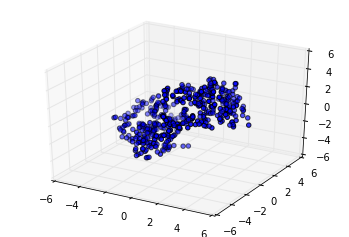

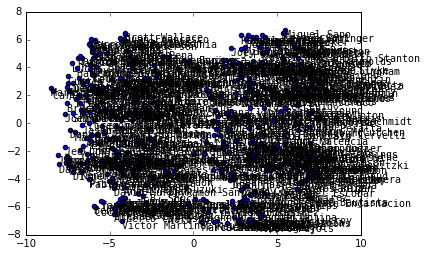

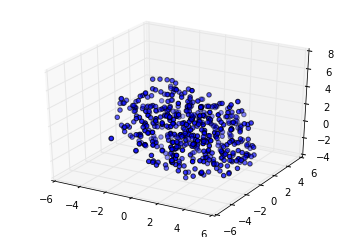

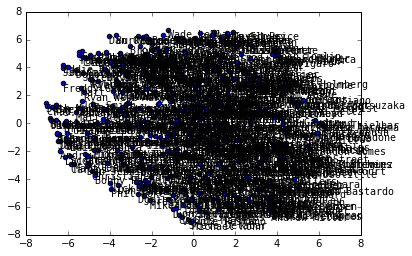

In [11]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

NUM_PLAYERS = {"batter": NUM_BATTERS, "pitcher": NUM_PITCHERS}


def run_tsne(player_type):    
    player_names = []
    for i in range(NUM_PLAYERS[player_type]):
        player_id = categories[player_type][i]
        player_names.append(player_data[player_id]["name"])
    
    tsne = TSNE(n_components = 3, learning_rate = 100)
    manifold_3d = tsne.fit_transform(player_vecs[player_type])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = "3d")
    ax.scatter(manifold_3d[:, 0], manifold_3d[:, 1], manifold_3d[:, 2])
    
    plt.show()
    
    tsne = TSNE(n_components = 2, learning_rate = 100)
    manifold_2d = tsne.fit_transform(player_vecs[player_type])
    (x, y) = (manifold_2d[:, 0], manifold_2d[:, 1])
    
    plt.scatter(x, y)
    for i in range(len(player_names)):
        plt.text(x[i], y[i], player_names[i], va = "top", family = "monospace")

    plt.show()
    
    return manifold_3d


tsne_batters = run_tsne("batter")
tsne_pitchers = run_tsne("pitcher")

Let's also visualize the first few PCs of a [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) of the embeddings and color them with various interesting properties.

In [12]:
import csv

playerID_to_retroID = {}
reader = csv.DictReader(open("Master.csv"))
for row in reader:
    playerID = row["playerID"]
    retroID = row["retroID"]
    playerID_to_retroID[playerID] = retroID

reader = csv.DictReader(open("Salaries.csv"))
salaries = {}
for row in reader:
    if row["yearID"] == "2015":
        playerID = row["playerID"]
        retroID = playerID_to_retroID[playerID]
        log_salary = np.log2(int(row["salary"]))
        salaries[retroID] = log_salary

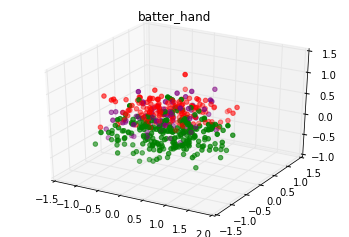

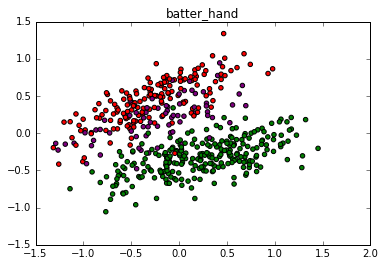

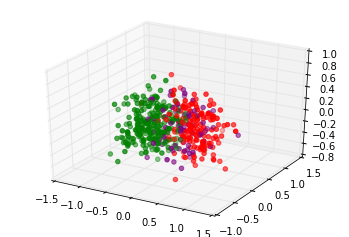

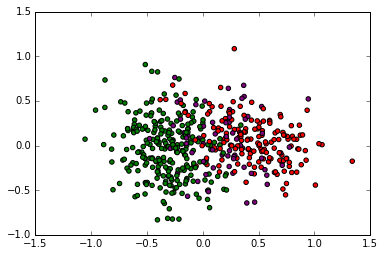

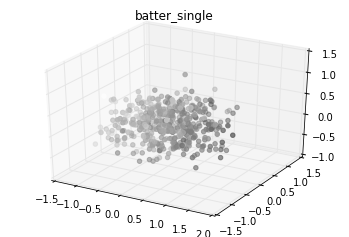

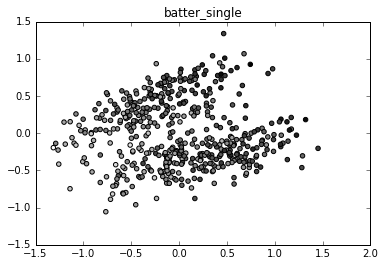

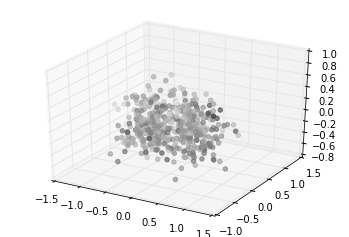

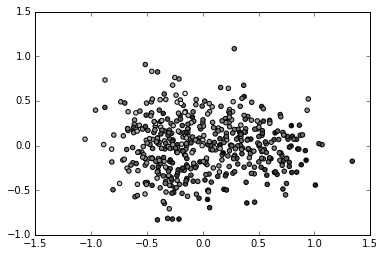

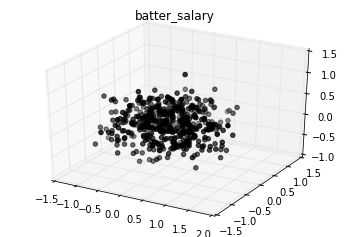

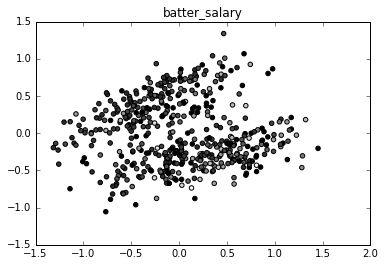

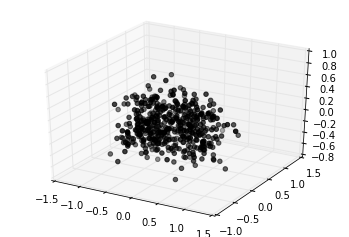

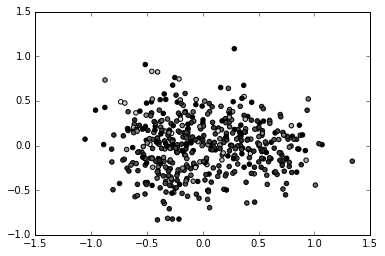

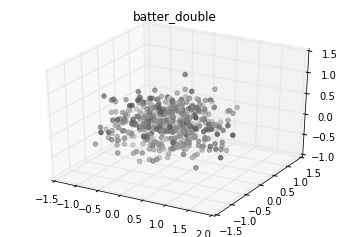

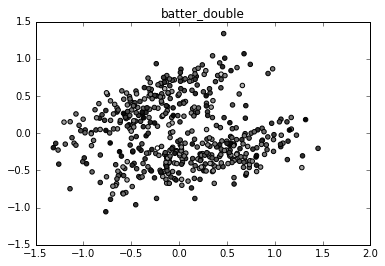

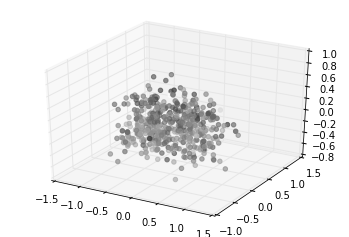

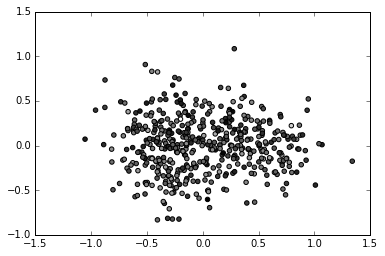

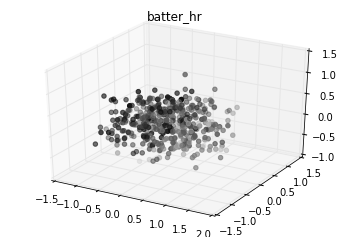

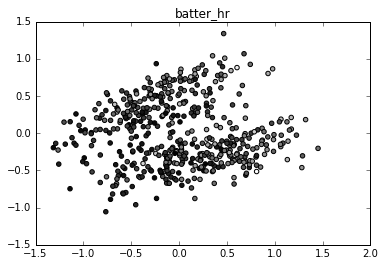

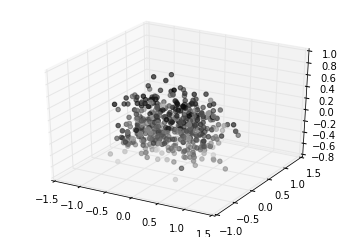

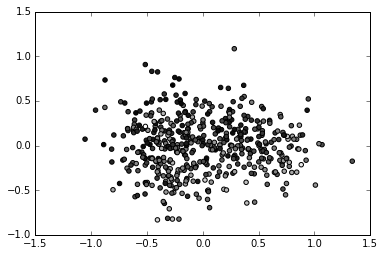

[ 0.32490306  0.2146834   0.10064377  0.07403285  0.03725624  0.02983005
  0.02698091  0.02379274  0.02011659  0.01851995  0.01737898  0.01434864
  0.01369905  0.01228099  0.01101503  0.01073273  0.00882015  0.00840532
  0.00797577  0.00678583  0.00646186  0.00480891  0.00263873  0.00223299
  0.00165545]


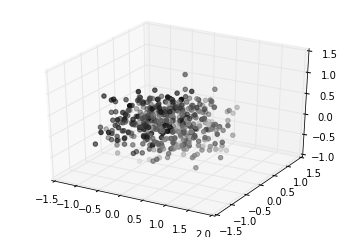

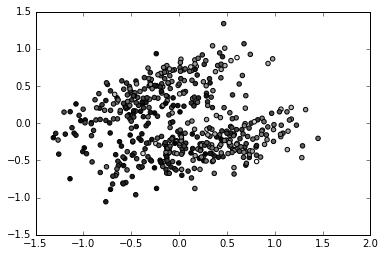

[ 0.27315181  0.12451555  0.09993311  0.06750275  0.05494421  0.03864468
  0.03546482  0.03119806  0.02859759  0.02570499  0.02493446  0.0231585
  0.02194974  0.02103458  0.0181793   0.01634364  0.01596104  0.01541853
  0.01344758  0.01137984  0.01073809  0.00973298  0.00734267  0.00561016
  0.00511133]


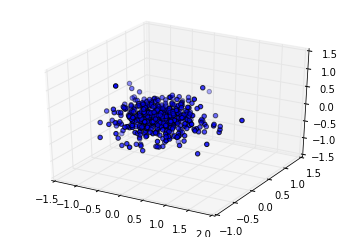

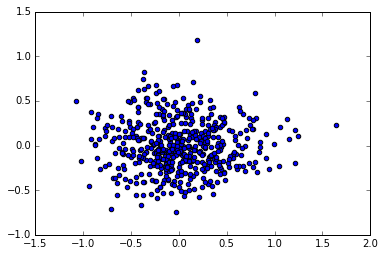

In [13]:
from sklearn import decomposition


def run_pca(player_vecs, colors = None, pc_x = 0, pc_y = 1, pc_z = 2, do_print = False, title = ""):
    """Run a PCA on the embedded player representations.
    
    :param player_vecs: 
    :param colors: 
    :param pc_x: 
    :param pc_y: 
    :param pc_z: 
    :return: 
    """
    pca = decomposition.PCA()
    pca.fit(player_vecs)
    if do_print:
        print(pca.explained_variance_ratio_)
    
    projected = pca.transform(player_vecs)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = "3d")
    ax.scatter(projected[:, pc_x], projected[:, pc_y], projected[:, pc_z], color = colors)
    ax.set_title(title)
    
    plt.show()
    
    plt.scatter(projected[:, pc_x], projected[:, pc_y], c = colors, cmap = "gray")
    plt.title(title)
    plt.show()
    return projected


max_hr_rate = max([home_runs.get(batter_id, 0) / at_bats[batter_id] for batter_id in at_bats if batter_id in categories["batter"]])
max_single_rate = max([singles.get(batter_id, 0) / at_bats[batter_id] for batter_id in at_bats if batter_id in categories["batter"]])
max_double_rate = max([doubles.get(batter_id, 0) / at_bats[batter_id] for batter_id in at_bats if batter_id in categories["batter"]])
max_salary = max([salaries.get(batter_id, 0) for batter_id in at_bats if batter_id in categories["batter"]])

batting_hand_color = {"L": "red", "R": "green", "B": "purple"}
batter_colors = {"hand": [], "hr": [], "single": [], "double": [], "salary": []}
for i in range(NUM_BATTERS):
    batter_id = categories["batter"][i]
    batting_hand = player_data[batter_id]["batting_hand"]
    batter_colors["hand"].append(batting_hand_color[batting_hand])
    batter_colors["hr"].append(str((home_runs.get(batter_id, 0) / at_bats[batter_id]) / max_hr_rate))
    batter_colors["single"].append(str((singles.get(batter_id, 0) / at_bats[batter_id]) / max_single_rate))
    batter_colors["double"].append(str((doubles.get(batter_id, 0) / at_bats[batter_id]) / max_double_rate))
    batter_colors["salary"].append(str((salaries.get(batter_id, 0) / at_bats[batter_id]) / max_salary))

for batter_color in ["hand", "single", "salary", "double", "hr"]:
    projected_batters = run_pca(batter_vecs, batter_colors[batter_color], title = "batter_{0}".format(batter_color))
    no = run_pca(batter_vecs, batter_colors[batter_color], 1, 2, 3)

projected_batters = run_pca(batter_vecs, batter_colors["hr"], do_print = True)
projected_pitchers = run_pca(pitcher_vecs, do_print = True)

As you can see, there are some interesting patterns emerging from the embeddings. For example, right-handed hitters are clearly separated from left-handed and switch hitters. Similarly, frequent singles hitters are far from infrequent singles hitters. So, the model is clearly learning something, but whether or not what it's learning is non-trivial remains to be seen.

Let's go ahead and save the t-SNE embeddings and PC scores to CSV files so that we can play around with them later if we want.

In [14]:
import csv


def write_projected_data(player_type, projected, fieldnames, projection):
    """Write the projected scores of the players to a file.
    
    :param player_type: 
    :param projected: 
    :param fieldnames: 
    :return: 
    """
    out = open("{0}s_{1}.csv".format(player_type, projection), "w")
    output = csv.DictWriter(out, fieldnames = fieldnames)
    output.writeheader()
    
    for i in range(NUM_PLAYERS[player_type]):
        player_id = categories[player_type][i]
        row = {}
        for col in fieldnames:
            if col in player_data[player_id]:
                row[col] = player_data[player_id][col]
        
        row["2015_salary"] = 2 ** salaries.get(player_id, 0)
        
        xyz = ["x", "y", "z"]
        for j in range(3):
            if projection == "pca":
                row["PC{0}".format(j + 1)] = projected[i][j]
            else:
                row[xyz[j]] = projected[i][j]
        
        row["player_id"] = player_id
        if player_type == "batter":
            row["hr_rate"] = home_runs.get(player_id, 0) / at_bats[player_id]
        
        nothing = output.writerow(row)
    
    out.close()


fieldnames = ["player_id", "name", "2015_salary", "position", "batting_hand", "throwing_hand", "hr_rate", "PC1", "PC2", "PC3"]
write_projected_data("batter", projected_batters, fieldnames, "pca")
write_projected_data("batter", tsne_batters, fieldnames[:-3] + ["x", "y", "z"], "tsne")

fieldnames = ["player_id", "name", "2015_salary", "throwing_hand", "PC1", "PC2", "PC3"]
write_projected_data("pitcher", projected_pitchers, fieldnames, "pca")
write_projected_data("pitcher", tsne_pitchers, fieldnames[:-3] + ["x", "y", "z"], "tsne")

To get a more intuitive feel for the embeddings, I recommend exploring them in my open source [ScatterPlot3D](https://sites.google.com/view/michaelaalcorn/projects/scatterplot3d) software. To run it:

1. Download the appropriate build.
2. Run with <code>java -jar ScatterPlot3D-&lt;version&gt;.jar</code> on Linux systems or by double-clicking the JAR on Windows.
3. Load the data.
4. Put 5, 6, and 7 for x, y, and z for "pitchers_tsne.csv" or 8, 9, and 10 for "batters_tsne.csv".
5. Click "Submit".

You can then search, zoom, and rotate the data or click on individual points for more details. For example:

<img src="pitchers_tsne_all.png">

<img src="kluber.png">

Documentation can be downloaded [here](https://sites.google.com/view/michaelaalcorn/ScatterPlot3D/SupplementaryMaterials.zip?attredirects=0&d=1) and a gallery of application screenshots can be found [here](http://imgur.com/a/U833y).

Let's also save the raw player embeddings.

In [15]:
def write_distributed_representations(player_type, player_vecs):
    """Write the hidden vector representation of the players to a file.
    
    :param player_type: 
    :param player_vecs: 
    :return: 
    """
    out = open("{0}s_latent.csv".format(player_type), "w")
    fieldnames = ["name"] + ["latent_{0}".format(i + 1) for i in range(VEC_SIZE)]
    output = csv.DictWriter(out, fieldnames = fieldnames)
    output.writeheader()
    
    for i in range(NUM_PLAYERS[player_type]):
        player_id = categories[player_type][i]
        row = {"name": player_data[player_id]["name"]}
        
        for j in range(VEC_SIZE):
            row["latent_{0}".format(j + 1)] = player_vecs[i][j]
        
        nothing = output.writerow(row)
    
    out.close()


write_distributed_representations("batter", batter_vecs)
write_distributed_representations("pitcher", pitcher_vecs)

So, do these embeddings contain any non-obvious information? Maybe comparing nearest neighbors will provide some insight.

In [16]:
import pandas as pd


def get_nearest_neighbors(name, data, latent_vecs, player_names, k = 10):
    """Print the k nearest neighbors (in the latent space) of a given player.
    
    :param name: 
    :param data: 
    :param latent_vecs: 
    :param player_names: 
    :param k: 
    :return: 
    """
    player_index = np.where(data["name"] == name)[0]
    player_latent = latent_vecs[player_index]
    distances = list(np.linalg.norm(latent_vecs - player_latent, axis = 1))
    distances_and_ids = list(zip(player_names, distances))
    distances_and_ids.sort(key = lambda x: x[1])
    
    return distances_and_ids[1:1 + k]


data_files = ["batters_latent.csv", "pitchers_latent.csv"]
data = {}
player_names = {}
latent_vecs = {}
for player_type in ["batter", "pitcher"]:
    data_file = "{0}s_latent.csv".format(player_type)
    data[player_type] = pd.read_csv(data_file)
    player_names[player_type] = list(data[player_type]["name"])
    latent_vecs[player_type] = np.array(data[player_type].iloc[:, 1:])

print("Mike Trout")
print(get_nearest_neighbors("Mike Trout", data["batter"], latent_vecs["batter"], player_names["batter"]))
print()

print("Dee Gordon")
print(get_nearest_neighbors("Dee Gordon", data["batter"], latent_vecs["batter"], player_names["batter"]))
print()

print("Clayton Kershaw")
print(get_nearest_neighbors("Clayton Kershaw", data["pitcher"], latent_vecs["pitcher"], player_names["pitcher"]))
print()

print("Aroldis Chapman")
print(get_nearest_neighbors("Aroldis Chapman", data["pitcher"], latent_vecs["pitcher"], player_names["pitcher"]))
print()

Mike Trout
[('Paul Goldschmidt', 0.74845865849544579), ('Derek Norris', 0.79099393078713831), ('Justin Upton', 0.84652848752298349), ('Andrew McCutchen', 0.85421779752719051), ('Michael Cuddyer', 0.87524657103016945), ('Yasiel Puig', 0.89058903385963029), ('Francisco Cervelli', 0.89137043844978059), ('Josh Rutledge', 0.89991630078853113), ('Carlos Gomez', 0.90417897542404835), ('Jayson Werth', 0.90622307829976834)]

Dee Gordon
[('Carl Crawford', 0.72419348461056199), ('Billy Burns', 0.75077453200979483), ('Ichiro Suzuki', 0.75317621453866046), ('Scooter Gennett', 0.78018069524286116), ('Francisco Lindor', 0.8103556088645183), ('Billy Hamilton', 0.83658246945631975), ('Kevin Kiermaier', 0.84713730956642219), ('Alexi Amarista', 0.85418944010979636), ('J.B. Shuck', 0.86023289424873561), ('Rougned Odor', 0.86624367899379018)]

Clayton Kershaw
[('Felix Hernandez', 0.6381008600681557), ('Madison Bumgarner', 0.64020399802932726), ('Corey Kluber', 0.64645655607289154), ('Johnny Cueto', 0.65929

At a first glance, the nearest neighbors found in the embeddings do seem to support baseball intuition. Both Mike Trout and Paul Goldschmidt are known for their [rare blend of speed and power](https://sports.vice.com/en_us/article/paul-goldschmidt-might-really-be-this-good). Like Dee Gordon, Carl Crawford, Billy Burns, and Ichiro Suzuki all have [impressive](http://m.mlb.com/news/article/165096680/billy-burns-leads-statcast-speed-rankings/) [speed](http://bleacherreport.com/articles/578009-mlb-power-rankings-carl-crawford-and-the-fastest-player-on-all-30-teams) and [a knack for being able to get on base](http://www.fangraphs.com/blogs/dee-gordon-has-been-going-full-ichiro/). In the pitching realm, Clayton Kershaw, Felix Hernandez, Madison Bumgarner and Corey Kluber [all](http://www.foxsports.com/mlb/just-a-bit-outside/story/behind-corey-kluber-s-success-is-a-truly-devastating-curveball-080814) [have](https://www.washingtonpost.com/news/fancy-stats/wp/2014/10/22/gif-of-the-week-madison-bumgarners-curveball/) [impressive curveballs](http://www.cbssports.com/mlb/news/clayton-kershaws-curve-and-the-best-pitches-of-2015-so-far/) while Aroldis Chapman and Andrew Miller are both tall, intimidating pitchers known for their [blistering fastballs](http://www.mensjournal.com/sports/articles/baseballs-100-miles-per-hour-club-w200986) and Craig Kimbrel is [also known for his fastball](https://www.scientificamerican.com/article/the-documentary-fastball-tosses-some-physics-at-fans/).

When clustering players using common MLB stats (e.g., HRs, RBIs), Mike Trout's ten nearest neighbors for the 2015 season are: Bryce Harper, Julio Daniel Martinez, Andrew McCuthcen, Justin Upton, Matt Carpenter, Joey Votto, Curtis Granderson, Kris Bryant, Chris Davis, and Brian Dozier (R code [here](https://github.com/airalcorn2/batter-pitcher-2vec/blob/master/raw_stats_neighbors.R)). So there is some overlap between the two neighborhood methods, but, intriguingly, the nearest neighbor from each method is not found in the neighborhood of the other method. Similarly, Ichirio isn't among Dee Gordon's ten nearest neighbors when clustering on MLB stats.

Another fun thing to try is analogies. As I mentioned at the beginning of this notebook, word2vec embeddings contain interesting analogy properties. [Erik Erlandson](https://www.linkedin.com/in/erikerlandson), a colleague of mine at Red Hat, suggested I use average vectors for right-handed and left-handed batters to generate opposite handed dopplegängers for different players. Let's see what that looks like.

In [17]:
average_batters = {"R": [], "L": [], "B": []}

for player_id in player_data:
    hand = player_data[player_id]["batting_hand"]
    name = player_data[player_id]["name"]
    batter_index = np.where(data["batter"]["name"] == name)[0]
    batter_latent = latent_vecs["batter"][batter_index]
    if len(batter_latent) > 0:
        average_batters[hand] += [batter_latent]

for batting_hand in average_batters:
    average_batters[batting_hand] = np.array(average_batters[batting_hand]).mean(axis = 0)

In [18]:
def get_opposite_hand(name, batting_hand, data, latent_vecs, player_names, k = 10):
    """Find the player's opposite batting hand doppelgänger.
    
    :param name: 
    :param batting_hand: 
    :param data: 
    :param latent_vecs: 
    :param player_names: 
    :param k: 
    :return: 
    """
    player_index = np.where(data["name"] == name)[0]
    player_latent = latent_vecs[player_index]
    opposite_hand = None
    if batting_hand == "R":
        opposite_hand = player_latent - average_batters["R"] + average_batters["L"]
    else:
        opposite_hand = player_latent - average_batters["L"] + average_batters["R"]
    
    distances = list(np.linalg.norm(latent_vecs - opposite_hand, axis = 1))
    distances_and_ids = list(zip(player_names, distances))
    distances_and_ids.sort(key = lambda x: x[1])
    
    return distances_and_ids[1:1 + k]


print("Mike Trout")
print(get_opposite_hand("Mike Trout", "R", data["batter"], latent_vecs["batter"], player_names["batter"]))
print()

print("Dee Gordon")
print(get_opposite_hand("Dee Gordon", "L", data["batter"], latent_vecs["batter"], player_names["batter"]))
print()

Mike Trout
[('Dexter Fowler', 0.73030435689961282), ('Brad Miller', 0.78080923527433466), ('Bryce Harper', 0.7910895690712566), ('Michael Saunders', 0.82414360237378337), ('Anthony Rizzo', 0.83978654907843464), ('Seth Smith', 0.84109103221554382), ('Shin-Soo Choo', 0.84748390298479814), ('Alex Gordon', 0.86078679439809447), ('Freddie Freeman', 0.8761798425803603), ('John Jaso', 0.88150860440668266)]

Dee Gordon
[('Starlin Castro', 0.84271244735567363), ('Eduardo Nunez', 0.87154835892011873), ('Joaquin Arias', 0.88740823483735853), ('Zack Cozart', 0.90209976958929683), ('Maikel Franco', 0.91422011323561214), ('Dee Gordon', 0.916661093796864), ('James McCann', 0.92004458937633893), ('Kevin Pillar', 0.9224038701285856), ('Jordy Mercer', 0.92296670668464853), ('Jeff Bianchi', 0.93047514714818058)]



Bryce Harper's presence among Mike Trout's left-handed dopplegängers [is particularly satisfying](http://www.sportingnews.com/mlb/news/sn50-2016-best-baseball-players-mike-trout-bryce-harper/mk3kmorbiyhr1f7onb7t5pehq).

As for Dee Gordon's right-handed dopplegängers, [Eduardo Núñez's speed isn't exactly a secret](http://m.mlb.com/video/topic/73955164/v1177066683/sflad-nunez-peaks-at-22-mph-in-sprint-to-first).